<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/kaggle_nlp/blob/main/np_residual_learning_tuning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# residual learning 튜닝
가능한 실험 방향
* 의미 없는 feature 없애고 lgbm
* neural prophet 트레인 구간 줄여보기
* neural prophet 트레인구간 줄인거랑 안줄인거 예측 결과 비교해보기 (neural prophet의 능력 실험) 

* => 그래프로 비교해봐도 되고, 구간 잘라서 submission 해도 되고

* 여기서는 residual learning을 하는 구간을 많이 늘렸다.

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
os.chdir('/content/gdrive/My Drive/dacon_timeseries')

In [ ]:
!pip install neuralprophet

     |████████████████████████████████| 61kB 1.7MB/s 
     |████████████████████████████████| 748.8MB 19kB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [ ]:
dangjin_fcst= pd.read_csv('dangjin_fcst_data.csv')
dangjin_obs= pd.read_csv('dangjin_obs_data.csv')
energy = pd.read_csv('energy.csv') # 발전소별 발전량
sample_submission = pd.read_csv('sample_submission.csv')
site_info = pd.read_csv('site_info.csv') # 발전소 정보
ulsan_fcst = pd.read_csv('ulsan_fcst_data.csv')
ulsan_obs= pd.read_csv('ulsan_obs_data.csv')

# EDA

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from glob import glob
import plotly.express as px
from neuralprophet import NeuralProphet

## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Forecast 데이터 전처리

In [ ]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [ ]:
#여기서는 14시 예보만을 사용
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]
#다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(다음날 00:00)부터 33시간 후(23:00) 데이터만 사용
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

In [ ]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized



In [ ]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [ ]:
#1시간 단위 데이터프레임 생성
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [ ]:
#3시간 단위인거 1시간 단위로 채우기 (merge, interpolate(선형보간))
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer') #NaN 있는 상태의 1시가 간격 df 만들어짐
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [ ]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [ ]:
#dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)  #이거 해주면 train_datast에서 astype(int) 해줘야함
#ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [ ]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    
    concat_df['hour'] = concat_df['Forecast_time'].dt.hour#.astype(int)
    concat_df['year'] = concat_df['Forecast_time'].dt.year#.astype(int)
    concat_df['month'] = concat_df['Forecast_time'].dt.month#.astype(int)
    concat_df['day'] = concat_df['Forecast_time'].dt.day#.astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 5일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*5]
    val_df = feature_df.iloc[-24*5:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target]#.to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## energy 데이터 전처리
- time : 1시간 단위 계량된 시간  
  (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [ ]:
energy.shape

(25632, 5)

In [ ]:
energy # 2018-3-1 ~ 2021-1-31 1시간 단위로 기록된 각 발전소별 발전량 데이터

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [ ]:
energy['date'] = energy['time'].apply(lambda x: x.split()[0])
energy['time'] = energy['time'].apply(lambda x: x.split()[1])
energy['time'] = energy['time'].str.rjust(8,'0') # 한자릿수 시간 앞에 0 추가 ex) 3시 -> 03시

In [ ]:
from datetime import timedelta

# 24시를 00시로 바꿔주기
energy.loc[energy['time']=='24:00:00','time'] = '00:00:00'
energy['time'] = energy['date'] + ' ' + energy['time']
energy['time'] = pd.to_datetime(energy['time'])
energy.loc[energy['time'].dt.hour==0,'time'] += timedelta(days=1)
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,date
0,2018-03-01 01:00:00,0.0,0.0,0,0,2018-03-01
1,2018-03-01 02:00:00,0.0,0.0,0,0,2018-03-01
2,2018-03-01 03:00:00,0.0,0.0,0,0,2018-03-01
3,2018-03-01 04:00:00,0.0,0.0,0,0,2018-03-01
4,2018-03-01 05:00:00,0.0,0.0,0,0,2018-03-01
...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0,2021-01-31
25628,2021-01-31 21:00:00,0.0,0.0,0,0,2021-01-31
25629,2021-01-31 22:00:00,0.0,0.0,0,0,2021-01-31
25630,2021-01-31 23:00:00,0.0,0.0,0,0,2021-01-31


- 데이터의 row는 25632개가 있어 약 일주일 정도의 에너지 발전량을 시각화해보자.
- 용량이 큰 당진이 대체로 많이 발전하고, 
- 용량이 적은 울산이 대체로 적게 발전
- 3월 4일 경에는 모든 발전소의 발전량이 낮은데 아무래도 날씨의 영향인 것 같다.

In [ ]:
# time column을 분해하여 의미있을 것 같은 month와 hour로 시각화해보자.
energy['month'] = energy['time'].dt.month
energy['hour'] = energy['time'].dt.hour

# NeuralProphet
* Energy 값만 사용하는 방식

In [ ]:
def sola_nmae(answer, pred, cap):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= cap
    
    target_idx = np.where(answer>=cap*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [ ]:
train_en = energy[:-24*365] # 18년 3월 1일 ~ 20년 2월 1일
test_en = energy[-24*365:] # 20년 2월 2일 ~ 21년 1월 31일

In [ ]:
# validation, 시각화를 위한 함수
def make_val(colo, cap, train_df): 
  column = colo
  df = pd.DataFrame()
  df['ds'] = train_df['time']
  df['y'] = train_df[column]
  df.y = df.y.fillna(0)
  train = df[:-24*30] #자체 train, val이라서 1달
  val = df[-24*30:] #자체 val

# Neural Prophet 설명 - http://insightcampus.co.kr:9090/insightcommunity/?mod=document&uid=12964

  model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True)
  loss = model.fit(train, freq="H")
  df_pred = model.make_future_dataframe(train, periods=24*30)  #train 데이터 이후로 periods만큼 예측
  predict = model.predict(df_pred)

  #visualization
  plt.figure(figsize=(20,5))
  plt.plot(np.maximum(0,predict['yhat1'].values), label='pred')
  plt.plot(val.y.values, label='Actual') 
  plt.legend()
  print('CV Score : ', sola_nmae(val.y.values, np.maximum(0,predict['yhat1'].values), cap))
  plt.show()

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s, SmoothL1Loss=0.0152, MAE=69.5, RegLoss=0]


CV Score :  6.138132559535014


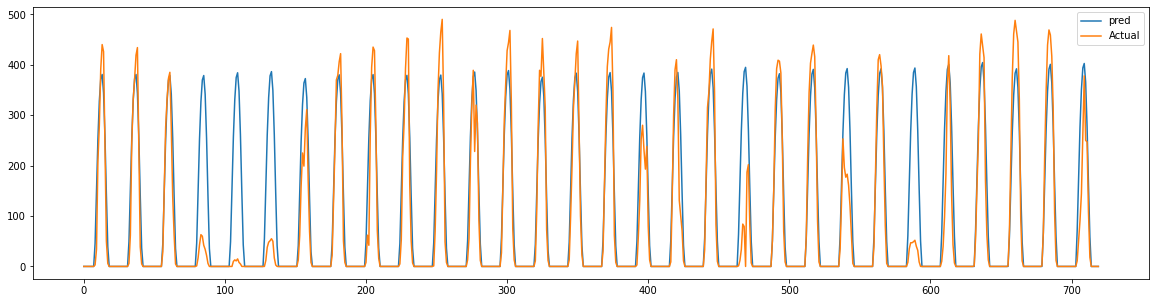

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, SmoothL1Loss=0.0153, MAE=51.5, RegLoss=0]


CV Score :  11.12220403561114


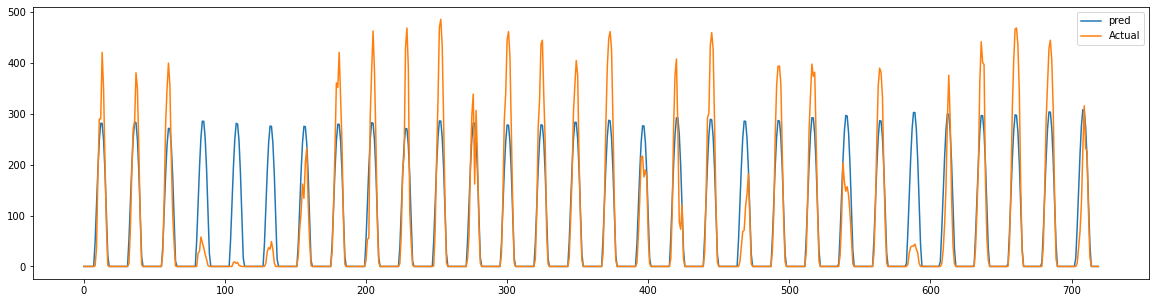

In [ ]:
make_val('dangjin_floating', 1000, train_en)
make_val('dangjin_warehouse', 700, train_en)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s, SmoothL1Loss=0.0148, MAE=77.8, RegLoss=0]


CV Score :  8.728404962876263


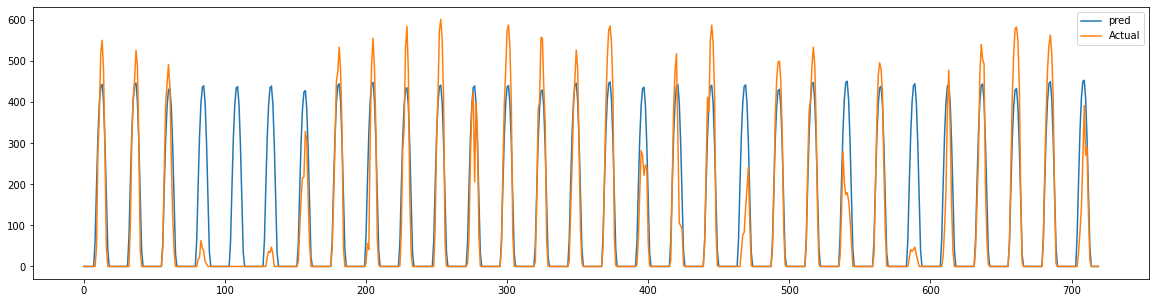

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s, SmoothL1Loss=0.0156, MAE=36.1, RegLoss=0]


CV Score :  11.676659220740907


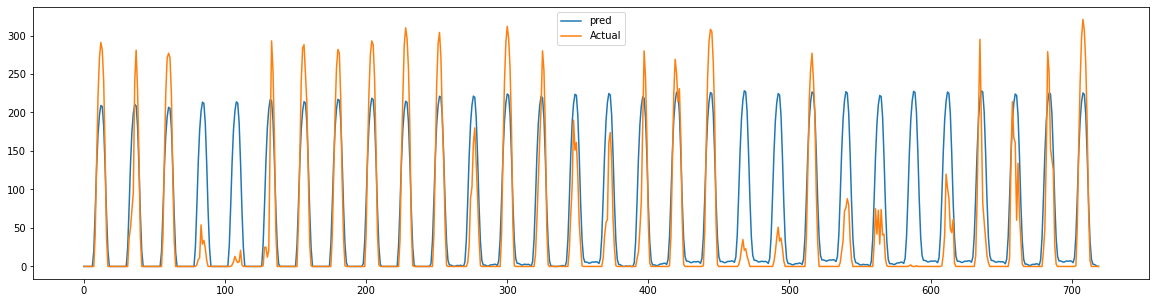

In [ ]:
make_val('dangjin', 1000, train_en)
make_val('ulsan', 500, train_en)

In [ ]:
def train_np(colo, train_df):
  column = colo
  df = pd.DataFrame()
  df['ds'] = train_df['time']
  df['y'] = train_df[column]
  df.y = df.y.fillna(0)

  model = NeuralProphet(yearly_seasonality=True, daily_seasonality=True)
  loss = model.fit(df, freq="H")

  #predict
  df_pred = model.make_future_dataframe(df, periods=9000)
  predict = model.predict(df_pred)

  return predict

In [ ]:
flt_pred = train_np('dangjin_floating', train_en)
ware_pred = train_np('dangjin_warehouse', train_en)
d_pred = train_np('dangjin', train_en)
u_pred = train_np('ulsan', train_en)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, SmoothL1Loss=0.0154, MAE=69.9, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s, SmoothL1Loss=0.0153, MAE=51.3, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s, SmoothL1Loss=0.0148, MAE=77.7, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s, SmoothL1Loss=0.0156, MAE=36.2, RegLoss=0]


In [ ]:
flt_pred # 2020년 2월 2일 ~ 2021년 2월 11일

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2020-02-02 01:00:00,None,-34.657608,None,108.049698,-18.279001,-3.195650,-121.232666
1,2020-02-02 02:00:00,None,-36.952778,None,108.046844,-18.245918,-3.595845,-123.157860
2,2020-02-02 03:00:00,None,-41.306953,None,108.043991,-18.212847,-3.961787,-127.176308
3,2020-02-02 04:00:00,None,-41.501526,None,108.041122,-18.179800,-4.290643,-127.072212
4,2020-02-02 05:00:00,None,-37.790482,None,108.038284,-18.146765,-4.579984,-123.102013
...,...,...,...,...,...,...,...,...
8995,2021-02-10 20:00:00,None,-45.786995,None,82.364853,-11.155150,-0.108247,-116.888451
8996,2021-02-10 21:00:00,None,-50.618473,None,82.362000,-11.125647,-0.303837,-121.550995
8997,2021-02-10 22:00:00,None,-54.285072,None,82.359131,-11.096153,-0.513129,-125.034935
8998,2021-02-10 23:00:00,None,-56.372391,None,82.356277,-11.066669,-0.734308,-126.927704


## 원래 submission (residual learning에서 실행 X)

In [ ]:
def sub(predict, col, file):
  # 2021-02-01 ~ 2021-03-01
  predict_1 = predict.copy()
  predict_1 = predict_1.query('ds >= "2021-02-01 00:00:00"')
  predict_1 = predict_1.query('ds <= "2021-03-01 00:00:00"') #submission 파일에는28일 24시로 되어있음
  #print(predict_1)
  # 2021-06-09 ~ 2021-07-09
  predict_2 = predict.copy()
  predict_2 = predict_2.query('ds > "2021-06-09 00:00:00"')
  predict_2 = predict_2.query('ds <= "2021-07-09 00:00:00"')
  #print(predict_2)
  file[col] = list(predict_1['yhat1']) + list(predict_2['yhat1'])
  
  return file


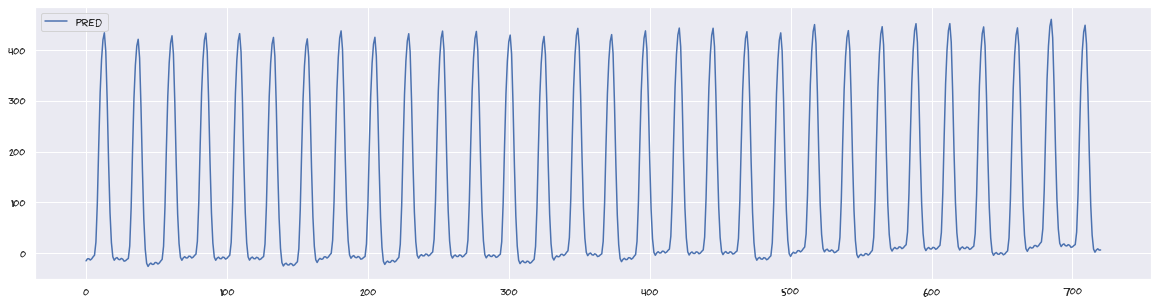

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(flt_pred.loc[:720,'yhat1'].values, label='pred')
plt.legend()
plt.show()

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
sub_file = sub(flt_pred, 'dangjin_floating', submission)
sub_file = sub(ware_pred, 'dangjin_warehouse', sub_file)
sub_file = sub(d_pred, 'dangjin', sub_file)
sub_file = sub(u_pred, 'ulsan', sub_file)

In [ ]:
sub_file

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-14.677555,-16.536736,-28.426849,0.905134
1,2021-02-01 02:00:00,-10.594124,-17.916872,-24.527168,0.275442
2,2021-02-01 03:00:00,-10.485455,-21.479921,-22.799957,0.220984
3,2021-02-01 04:00:00,-12.994946,-21.028902,-23.793522,2.686935
4,2021-02-01 05:00:00,-10.701351,-17.424858,-24.130058,3.267330
...,...,...,...,...,...
1387,2021-07-08 20:00:00,5.154404,-6.259411,7.490631,-2.662952
1388,2021-07-08 21:00:00,-1.268787,-4.270252,5.347076,-0.501461
1389,2021-07-08 22:00:00,2.849529,-2.978516,5.574989,-2.286572
1390,2021-07-08 23:00:00,4.757988,-4.316895,3.530472,-4.406937


In [ ]:
#sub_file.to_csv('neural_prophet_submission0512.csv', index =False)

* Prediction 그대로 냈을때 점수 13.66631 (109등 ;;)


# Residual energy파일

In [ ]:
def sub_res(predict, col, file): #predict해서 residual을 위한 구간만 추출하는 함수
  # 2021-02-01 ~ 2021-03-01
  predict_1 = predict.copy()
  predict_1 = predict_1.query('ds >= "2020-02-02 01:00:00"')
  predict_1 = predict_1.query('ds <= "2021-02-01 00:00:00"') #submission 파일에는28일 24시로 되어있음
  
  file[col] = list(predict_1['yhat1']) 
  
  return file

In [ ]:
pred4res = pd.DataFrame() #residual learning을 위한 np prediction 데이터

In [ ]:
pred4res['time']=test_en['time']

pred4res = sub_res(flt_pred, 'dangjin_floating', pred4res)
pred4res = sub_res(ware_pred, 'dangjin_warehouse', pred4res)
pred4res = sub_res(d_pred, 'dangjin', pred4res)
pred4res = sub_res(u_pred, 'ulsan', pred4res)

In [ ]:
pred4res  #np prediction에서 residual learning에 사용할 구간 가져오기

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
16872,2020-02-02 01:00:00,-34.657608,2.025280,-35.207237,-15.923980
16873,2020-02-02 02:00:00,-36.952778,2.594574,-34.723835,-18.022612
16874,2020-02-02 03:00:00,-41.306953,2.463524,-37.968597,-17.304070
16875,2020-02-02 04:00:00,-41.501526,2.299618,-38.219215,-14.203562
16876,2020-02-02 05:00:00,-37.790482,2.409336,-33.306801,-14.893016
...,...,...,...,...,...
25627,2021-01-31 20:00:00,-56.347198,28.329964,-109.406128,-69.163689
25628,2021-01-31 21:00:00,-60.658012,26.927193,-114.932983,-68.228531
25629,2021-01-31 22:00:00,-63.772427,28.332741,-114.956955,-68.852837
25630,2021-01-31 23:00:00,-65.281662,28.654465,-116.184586,-68.661346


In [ ]:
test_en.iloc[:,1:5]  #test energy

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
16872,0.0,0.0,0,0
16873,0.0,0.0,0,0
16874,0.0,0.0,0,0
16875,0.0,0.0,0,0
16876,0.0,0.0,0,0
...,...,...,...,...
25627,0.0,0.0,0,0
25628,0.0,0.0,0,0
25629,0.0,0.0,0,0
25630,0.0,0.0,0,0


In [ ]:
# 원래 값 - 예측 값 해서 residual을 구하기!
residual= test_en.iloc[:,1:5]-pred4res.iloc[:,1:]

In [ ]:
residual

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
16872,34.657608,-2.025280,35.207237,15.923980
16873,36.952778,-2.594574,34.723835,18.022612
16874,41.306953,-2.463524,37.968597,17.304070
16875,41.501526,-2.299618,38.219215,14.203562
16876,37.790482,-2.409336,33.306801,14.893016
...,...,...,...,...
25627,56.347198,-28.329964,109.406128,69.163689
25628,60.658012,-26.927193,114.932983,68.228531
25629,63.772427,-28.332741,114.956955,68.852837
25630,65.281662,-28.654465,116.184586,68.661346


# Residual Learning
진행 방향 ⇒ residual을 예측하는 부스팅계열 모델 만들기(날씨데이터 반영) 그리고 test에 대해 예측한 residual을 neural prophet 예측값에다가 더해주기.

neural prophet으로 예측 못한 부분을 부스팅 모델로 예측 해준다는 식.

In [ ]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [ ]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [ ]:
def residual_term(df):
  df = df.query('Forecast_time >= "2020-02-02 01:00:00"')
  df = df.query('Forecast_time <= "2021-02-01 00:00:00"')
  return df

In [ ]:
dangjin_fcst_r=residual_term(dangjin_fcst) #예보 데이터를 residual learning을 위한 구간으로 자름 (1월2일 ~ 2월 1일)

In [ ]:
ulsan_fcst_r=residual_term(ulsan_fcst)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [ ]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

### 당진수상태양광 예측 모델 학습

In [ ]:
residual

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
16872,34.657608,-2.025280,35.207237,15.923980
16873,36.952778,-2.594574,34.723835,18.022612
16874,41.306953,-2.463524,37.968597,17.304070
16875,41.501526,-2.299618,38.219215,14.203562
16876,37.790482,-2.409336,33.306801,14.893016
...,...,...,...,...
25627,56.347198,-28.329964,109.406128,69.163689
25628,60.658012,-26.927193,114.932983,68.228531
25629,63.772427,-28.332741,114.956955,68.852837
25630,65.281662,-28.654465,116.184586,68.661346


In [ ]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df#.loc[:25608] #25608-1에서 25608로 고치니까 val_x 끝까지 나옴 !
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    
    concat_df['hour'] = concat_df['Forecast_time'].dt.hour#.astype(int)
    concat_df['year'] = concat_df['Forecast_time'].dt.year#.astype(int)
    concat_df['month'] = concat_df['Forecast_time'].dt.month#.astype(int)
    concat_df['day'] = concat_df['Forecast_time'].dt.day#.astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 5일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*5]
    val_df = feature_df.iloc[-24*5:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target]#.to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [ ]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000

In [ ]:
# train_datast에서 to_numpy 빼고 df로 출력할때
#val_x #왜 719행 (2월 1일 00시)이 비어있지..?

In [ ]:
# 맨 마지막행 (index 719)가 알 수 없는 이유로 비어있어서 값 채워줌
#6.000000	80.000000	5.600000	177.000000	4.0
'''
val_x.year.fillna(2021.0, inplace=True)
val_x.month.fillna(2.0, inplace=True)
val_x.day.fillna(1.0, inplace=True)
val_x.hour.fillna(0.0, inplace=True)
val_x.Temperature.fillna(6.0, inplace=True)
val_x.Humidity.fillna(80.0, inplace=True)
val_x.WindSpeed.fillna(5.600000, inplace=True)
val_x.WindDirection.fillna(177.000000, inplace=True)
val_x.Cloud.fillna(4.0, inplace=True)
'''

In [ ]:
params_2 = {
    'learning_rate': 0.001,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [ ]:
dangjin_floating_model = lgb.train(params_2, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=1000) 

Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's l1: 30.6679	valid_0's score: 7.36582
[1000]	valid_0's l1: 28.4465	valid_0's score: 6.40543
[1500]	valid_0's l1: 26.9875	valid_0's score: 5.75102
[2000]	valid_0's l1: 25.8319	valid_0's score: 5.42899
[2500]	valid_0's l1: 24.678	valid_0's score: 5.19913
[3000]	valid_0's l1: 25.6524	valid_0's score: 5.50848
[3500]	valid_0's l1: 24.2151	valid_0's score: 5.45089
Early stopping, best iteration is:
[2522]	valid_0's l1: 24.6405	valid_0's score: 5.19448


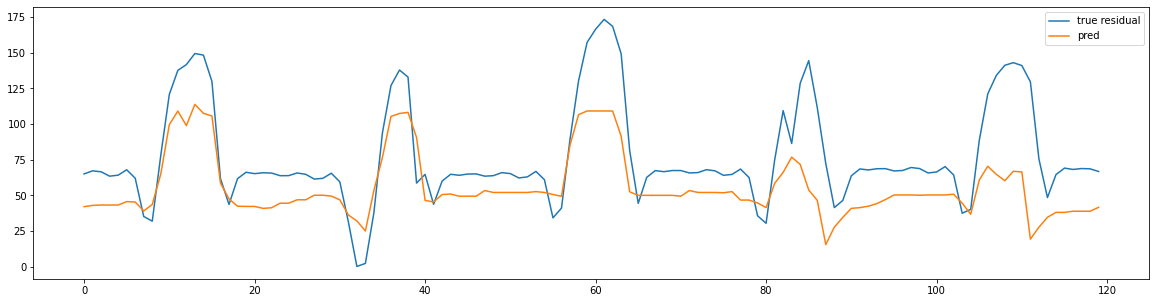

CV Score :  5.194480866100566


In [ ]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true residual')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

lr 줄이니까 학습이 되기 시작!

* xgboost

In [ ]:
import xgboost

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.001, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model.fit(train_x,train_y)
xg_pred = xgb_model.predict(val_x)

[11:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


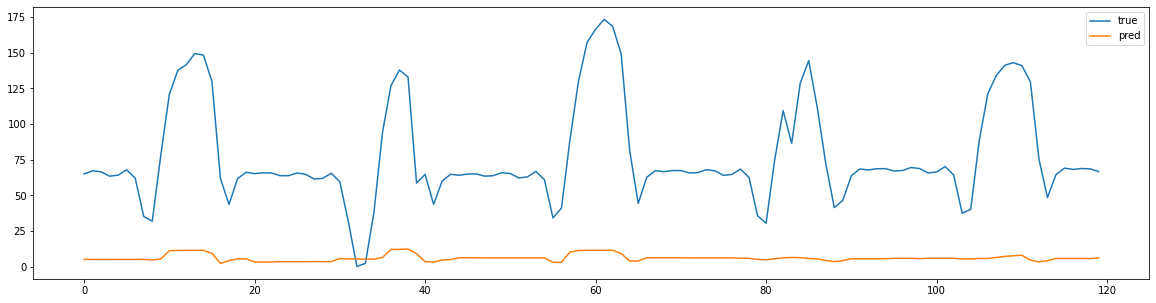

CV Score :  12.97039507102966


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(xg_pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, xg_pred))

* XGBoost 예측 무슨일....?

### 당진자재창고태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params_2, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=10000)

Training until validation scores don't improve for 10000 rounds.
[500]	valid_0's l1: 37.3002	valid_0's score: 19.5077
[1000]	valid_0's l1: 36.2583	valid_0's score: 18.71
[1500]	valid_0's l1: 36.2256	valid_0's score: 18.3132
[2000]	valid_0's l1: 36.0416	valid_0's score: 17.5323
[2500]	valid_0's l1: 35.8045	valid_0's score: 17.143
[3000]	valid_0's l1: 35.6914	valid_0's score: 17.0697
[3500]	valid_0's l1: 35.9182	valid_0's score: 17.2453
[4000]	valid_0's l1: 36.7453	valid_0's score: 17.67
[4500]	valid_0's l1: 38.0595	valid_0's score: 17.7985
[5000]	valid_0's l1: 38.2955	valid_0's score: 17.8535
[5500]	valid_0's l1: 38.2263	valid_0's score: 18.0294
[6000]	valid_0's l1: 38.3007	valid_0's score: 18.3744
[6500]	valid_0's l1: 38.5275	valid_0's score: 18.6392
[7000]	valid_0's l1: 38.738	valid_0's score: 18.6863
[7500]	valid_0's l1: 39.0747	valid_0's score: 18.7241
[8000]	valid_0's l1: 39.1531	valid_0's score: 18.8044
[8500]	valid_0's l1: 39.1878	valid_0's score: 18.9459
[9000]	valid_0's l1: 39.

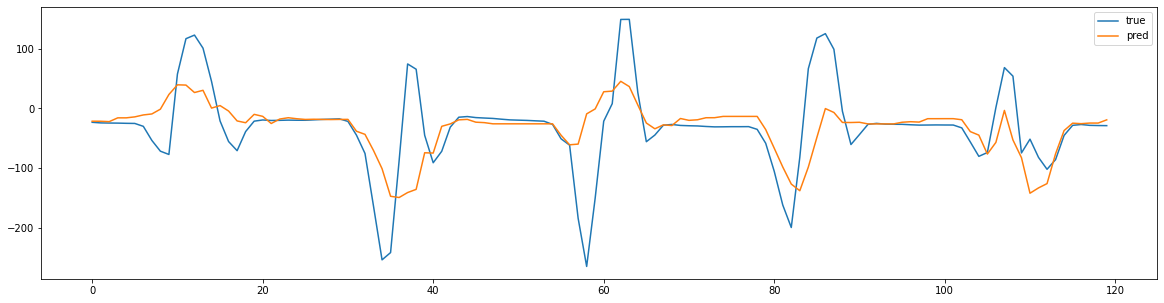

CV Score :  16.99751715110447


In [ ]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

얘는 학습이 되기는 됐는데.. 원래도 17 정도였음. residual에 쓰는 데이터를 늘려도 변화가 없네

lr 줄여도 16.99

### 당진태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(residual, dangjin_fcst_r, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=5000)

Training until validation scores don't improve for 5000 rounds.
[500]	valid_0's l1: 63.1894	valid_0's score: 7.03508
[1000]	valid_0's l1: 66.7951	valid_0's score: 7.2726
[1500]	valid_0's l1: 68.1521	valid_0's score: 7.48837
[2000]	valid_0's l1: 68.3686	valid_0's score: 7.59266
[2500]	valid_0's l1: 68.2887	valid_0's score: 7.62168
[3000]	valid_0's l1: 68.4776	valid_0's score: 7.68103
[3500]	valid_0's l1: 68.707	valid_0's score: 7.67618
[4000]	valid_0's l1: 68.7404	valid_0's score: 7.68283
[4500]	valid_0's l1: 69.0958	valid_0's score: 7.72358
[5000]	valid_0's l1: 69.2459	valid_0's score: 7.7452
Early stopping, best iteration is:
[491]	valid_0's l1: 63.1313	valid_0's score: 7.03868


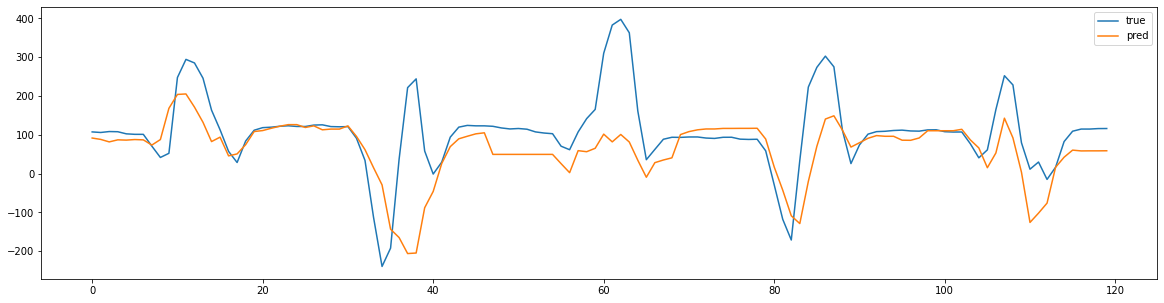

CV Score :  7.038679313114978


In [ ]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

이거는 눈에띄게, 그리고 수치적으로도 확 좋아짐 !! CV score 17에서 7로 좋아짐 !

### 울산태양광 예측 모델 학습

In [ ]:
train_x, train_y, val_x, val_y = train_datast(residual, ulsan_fcst_r, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
ulsan_model = lgb.train(params_2, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=10000)

Training until validation scores don't improve for 10000 rounds.
[500]	valid_0's l1: 30.6679	valid_0's score: 7.36582
[1000]	valid_0's l1: 28.4465	valid_0's score: 6.40543
[1500]	valid_0's l1: 26.9875	valid_0's score: 5.75102
[2000]	valid_0's l1: 25.8319	valid_0's score: 5.42899
[2500]	valid_0's l1: 24.678	valid_0's score: 5.19913
[3000]	valid_0's l1: 25.6524	valid_0's score: 5.50848
[3500]	valid_0's l1: 24.2151	valid_0's score: 5.45089
[4000]	valid_0's l1: 23.4846	valid_0's score: 5.48196
[4500]	valid_0's l1: 23.363	valid_0's score: 5.49503
[5000]	valid_0's l1: 22.7225	valid_0's score: 5.56221
[5500]	valid_0's l1: 22.2413	valid_0's score: 5.49848
[6000]	valid_0's l1: 21.8334	valid_0's score: 5.46989
[6500]	valid_0's l1: 21.6046	valid_0's score: 5.4653
[7000]	valid_0's l1: 21.299	valid_0's score: 5.43984
[7500]	valid_0's l1: 20.9983	valid_0's score: 5.40726
[8000]	valid_0's l1: 20.8469	valid_0's score: 5.40519
[8500]	valid_0's l1: 20.801	valid_0's score: 5.41959
[9000]	valid_0's l1: 20

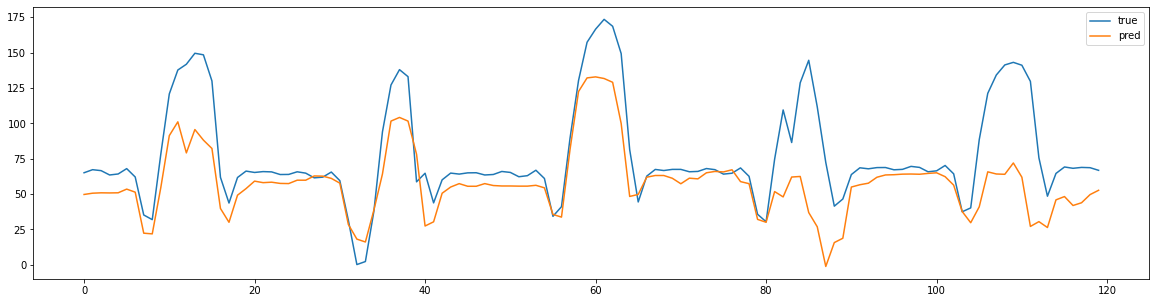

CV Score :  5.416892352919743


In [ ]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

예측이 전혀 안됐었는데, 예측이 잘됨 ㄷㄷㄷㄷㄷ 뭐지?
lr 줄여도 CV score 5정도로 비슷

## 테스트 데이터 전처리

In [ ]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df#.to_numpy()
    
    return test_x

In [ ]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [ ]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

# private test 구간 예측(2월)
* 각 발전소 발전량 residual 추론
* lgb 모델을 통해 2월 전체 구간 예측

In [ ]:
dangjin_test.shape

(672, 9)

In [ ]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

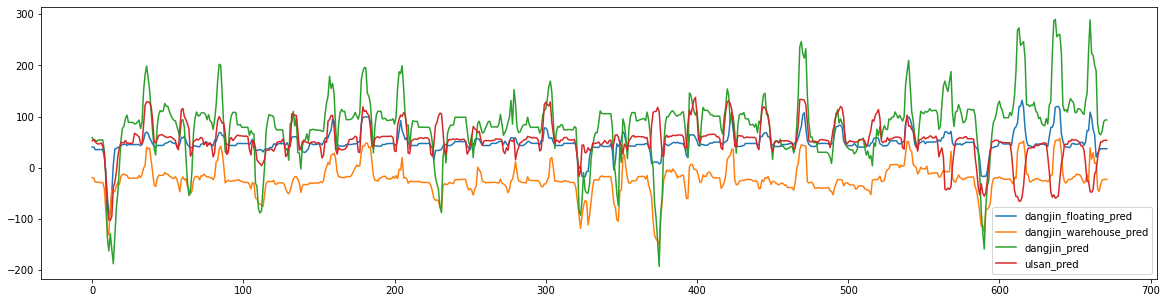

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [ ]:
neural_prophet_pred = pd.read_csv('neural_prophet_submission0512.csv')

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
dangjin_floating_pred.shape

(672,)

In [ ]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred

submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [ ]:
neural_prophet_pred.iloc[:24*28, 1:5]

,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,-14.677555,-16.536736,-28.426849,0.905134
1,-10.594124,-17.916872,-24.527168,0.275442
2,-10.485455,-21.479921,-22.799957,0.220984
3,-12.994946,-21.028902,-23.793522,2.686935
4,-10.701351,-17.424858,-24.130058,3.267330
...,...,...,...,...
667,9.373535,-9.670856,13.056694,9.023510
668,4.074512,-7.735554,11.300598,11.481537
669,9.306107,-6.539345,11.884155,9.987617
670,12.306854,-8.013561,10.161316,8.148678


In [ ]:
submission.iloc[:24*28, 1:5]=submission.iloc[:24*28, 1:5]+neural_prophet_pred.iloc[:24*28, 1:5]

In [ ]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,25.798709,-35.682339,30.562360,53.598717
1,2021-02-01 02:00:00,29.902881,-37.813229,29.554942,55.547404
2,2021-02-01 03:00:00,24.885264,-49.327068,31.405984,50.779681
3,2021-02-01 04:00:00,22.375773,-49.046684,27.170877,50.305381
4,2021-02-01 05:00:00,24.875550,-45.442640,30.196892,49.602961
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [ ]:
submission.to_csv('residual_learning_tuned.csv', index=False)

In [ ]:
lgb_947=pd.read_csv('xgboost_9.47.csv')

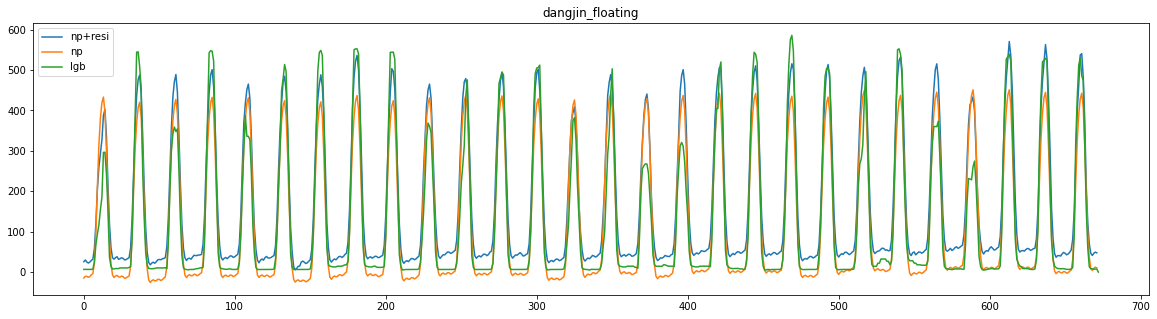

In [ ]:
#LGBM 9.47 score랑 같이 찍어본 dangjin_floating
plt.figure(figsize=(20,5))
plt.title('dangjin_floating')
plt.plot(dangjin_floating_pred + neural_prophet_pred.iloc[:24*28, 1] , label = 'np+resi')
plt.plot(neural_prophet_pred.iloc[:24*28, 1], label = 'np') #gt를 못찾겠네 ;
plt.plot(lgb_947.loc[:24*28,'dangjin_floating'], label = 'lgb')
plt.legend()
plt.show()

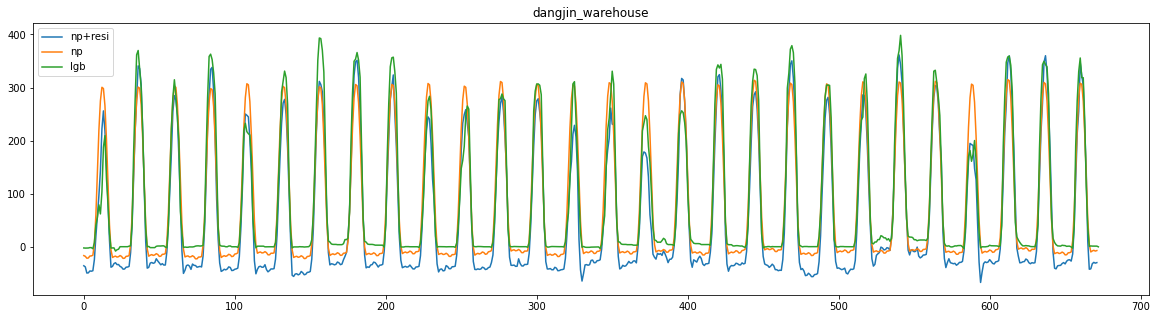

In [ ]:
#dangjin_warehouse plot
plt.figure(figsize=(20,5))
plt.title('dangjin_warehouse')
plt.plot(dangjin_warehouse_pred + neural_prophet_pred.iloc[:24*28, 2] , label = 'np+resi')
plt.plot(neural_prophet_pred.iloc[:24*28, 2], label = 'np') #gt를 못찾겠네 ;
plt.plot(lgb_947.loc[:24*28,'dangjin_warehouse'], label = 'lgb')
plt.legend()
plt.show()

submission score 10.45!! 많이 나아졌다 